In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
mnist_dataset = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

binary_train_images = train_images[(train_labels == 1) | (train_labels == 7)]
binary_train_labels = train_labels[(train_labels == 1) | (train_labels == 7)]

binary_test_images = test_images[(test_labels == 1) | (test_labels == 7)]
binary_test_labels = test_labels[(test_labels == 1) | (test_labels == 7)]

binary_train_images = binary_train_images / 255.0
binary_test_images = binary_test_images / 255.0

categorical_train_labels = ((binary_train_labels == 1).astype(np.float64).reshape((-1, 1)))
categorical_test_labels = (binary_test_labels == 1).astype(np.float64).reshape((-1, 1))

In [3]:
shapley_data = np.load("../output/shapley_model_on_binary_mnist_lr.npz")
shapley_values = shapley_data["shapley_values"]

In [15]:
num_training_points = 1000
num_test_points = 500

## Most/Least Valuable Points

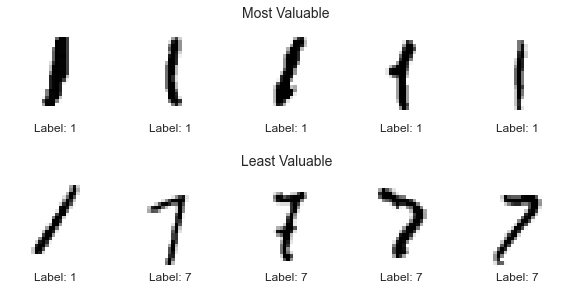

In [4]:
# Using loss as performance metric, so negative values are helpful, and positive values are harmful.
shapley_idxs = np.argsort(shapley_values)

cols = 5

fig, ax = plt.subplots(
    2,
    cols,
    subplot_kw={'xticks':[], 'yticks':[]},
    figsize=(2*cols, 5)
)

ax[0, cols//2].set_title("Most Valuable", fontdict={'fontsize': 14})
ax[1, cols//2].set_title("Least Valuable", fontdict={'fontsize': 14})

for i in range(cols):
    
    ax[0, i].imshow(binary_train_images[shapley_idxs[i]], cmap=plt.cm.binary)
    ax[0, i].set_xlabel("Label: {}".format(binary_train_labels[shapley_idxs[i]]))
    
    ax[1, i].imshow(binary_train_images[shapley_idxs[-i-1]], cmap=plt.cm.binary)
    ax[1, i].set_xlabel("Label: {}".format(binary_train_labels[shapley_idxs[-i-1]]))

## Overall Distribution

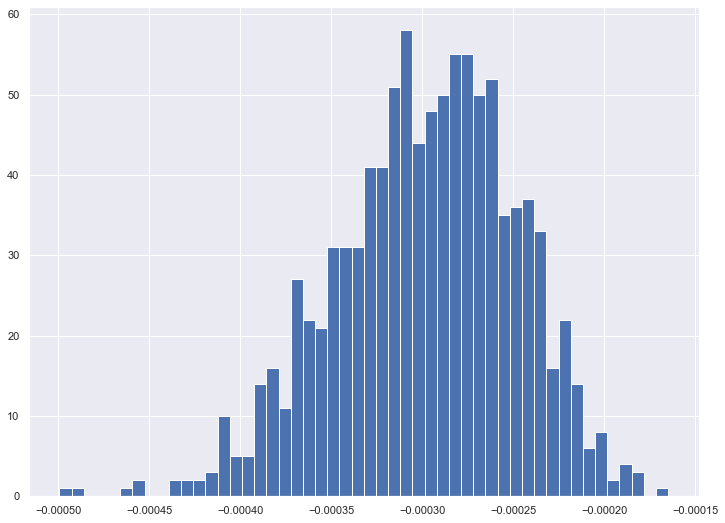

In [5]:
plt.figure(figsize=(12, 9))
plt.hist(shapley_values, bins=50)
plt.show()

## Re-Trained Model Performance

In [106]:
tf.keras.backend.set_floatx("float64")

model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(1, kernel_regularizer="l2", use_bias=False),
    ]
)

In [107]:
untrained_model = tf.keras.models.clone_model(model)
full_model = tf.keras.models.clone_model(model)
random_model = tf.keras.models.clone_model(model)
good_model = tf.keras.models.clone_model(model)
bad_model = tf.keras.models.clone_model(model)

In [108]:
models = [untrained_model, full_model, random_model, good_model, bad_model]
labels = ["Untrained", "All", "Random", "Most Valuable", "Least Valuable"]
metrics = ["Loss", "Accuracy"]

In [109]:
num_retrain_points = 200

random = np.random.choice(np.arange(num_training_points), size=num_retrain_points, replace=False)
shapley_idxs = np.argsort(shapley_values)

for m in models:
    m.compile(
        optimizer="adam",
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

full_model.fit(
    binary_train_images[:num_training_points],
    categorical_train_labels[:num_training_points],
    shuffle=False
)
random_model.fit(
    binary_train_images[random],
    categorical_train_labels[random],
    shuffle=False
)
good_model.fit(
    binary_train_images[shapley_idxs[:num_retrain_points]],
    categorical_train_labels[shapley_idxs[:num_retrain_points]],
    shuffle=False
)
bad_model.fit(
    binary_train_images[shapley_idxs[-num_retrain_points:]],
    categorical_train_labels[shapley_idxs[-num_retrain_points:]],
    shuffle=False
)

7/7 [==============================] - 0s 714us/step - loss: 0.7445 - accuracy: 0.6300


In [110]:
performances = np.array([
    m.evaluate(binary_test_images[:num_test_points], categorical_test_labels[:num_test_points]) for m in models
]).T

16/16 [==============================] - 0s 500us/step - loss: 0.7546 - accuracy: 0.4720


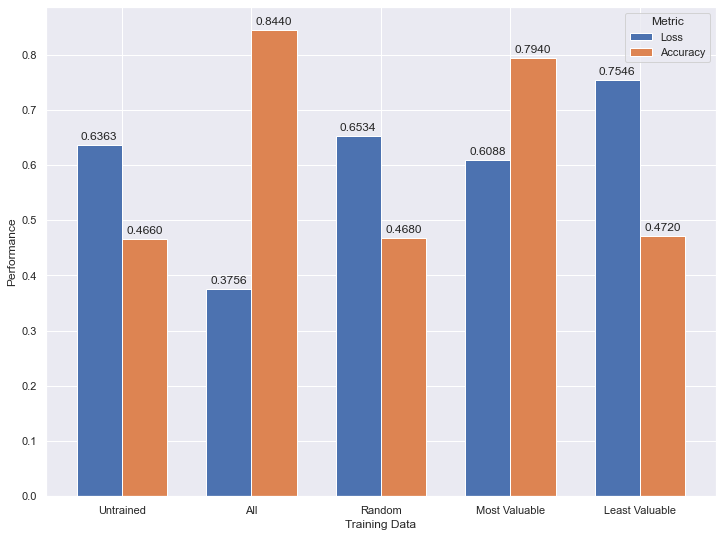

In [111]:
fig, ax = plt.subplots(figsize=(12, 9))

x = np.arange(len(models))
width = 0.7 / len(metrics)

for i in range(len(metrics)):
    
    rects = ax.bar(x+i*width, performances[i], width, label=metrics[i])
    
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "{:.4f}".format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom"
        )
        
    ax.set_ylabel("Performance")
    ax.set_xlabel("Training Data")
    ax.set_xticks(x+0.35-width/2)
    ax.set_xticklabels(labels)
    ax.legend(title="Metric", loc="upper right")